In [1]:
import params 
import numpy as np
import matplotlib.pyplot as plt 

In [4]:
train_data = np.load(params.datafile)
train_label = np.load(params.labelfile)

test_data = np.load(params.testfile)
test_label = np.load(params.testlabelfile)

In [5]:
print(train_data.shape)
print(test_data.shape)

(459106, 200)
(588563, 200)


19398 81847
[4.30432697e-03 8.39143722e-04 5.32475361e-03 1.15034649e-02
 1.57482838e-02 1.97653923e-02 7.99418715e-03 1.60860945e-03
 1.19231286e-04 1.17368245e-03 1.16218282e-02 3.14550195e-02
 7.08094408e-03 2.30849706e-02 1.30135471e-02 1.82536910e-03
 6.03933611e-03 9.72300194e-04 2.14947876e-02 3.70828139e-02
 3.21799891e-03 4.64117349e-03 7.48843685e-03 4.68566826e-03
 5.83534689e-03 6.33583424e-03 1.57906158e-02 1.30858787e-02
 5.26560866e-03 1.21110122e-02 2.26285151e-03 3.38923071e-03
 3.45218678e-04 3.86482891e-03 5.43190934e-03 2.54798399e-03
 4.61965836e-02 5.09466358e-01 9.47245741e-01 9.78478579e-01
 1.00000000e+00 9.73140067e-01 3.46530576e-01 4.15342247e-01
 1.01867693e-01 1.01435900e-01 1.98899744e-02 3.87508141e-02
 8.14078836e-02 8.43381357e-02 4.98648716e-02 3.45961943e-02
 5.78783909e-02 1.32679703e-01 5.14750946e-02 2.76583667e-02
 5.76592120e-02 3.85749630e-02 9.98288401e-02 1.98522352e-01
 8.39054738e-02 1.66763761e-01 1.15487714e-01 1.79691997e-02
 2.13647638e

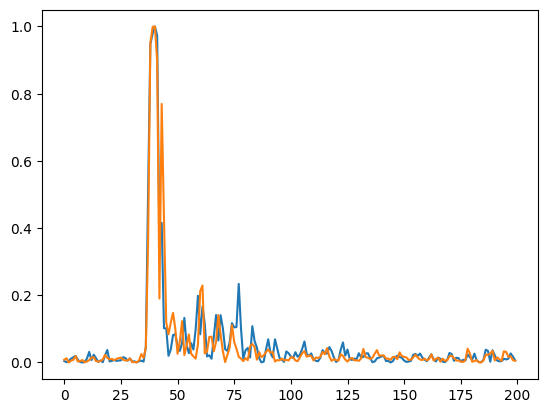

In [7]:
# Sample 1 train and 1 test
r1, r2 = np.random.choice(100000, 2)
print(r1, r2)
X1 = train_data[r1]
X2 = test_data[r2]

print(X1)

plt.plot(X1)
plt.plot(X2)

plt.show()

9.999950000398841e-06 -11.512925464970229
9.999950000398841e-06 -11.512925464970229
9.999950000398841e-06 -8.28430561269257
9.999950000398841e-06 -11.512925464970229
9.999950000398841e-06 -11.512925464970229
9.999950000398841e-06 -11.512925464970229
9.999950000398841e-06 -11.512925464970229
9.999950000398841e-06 -11.512925464970229
9.999950000398841e-06 -11.512925464970229
9.999950000398841e-06 -6.528585444311003


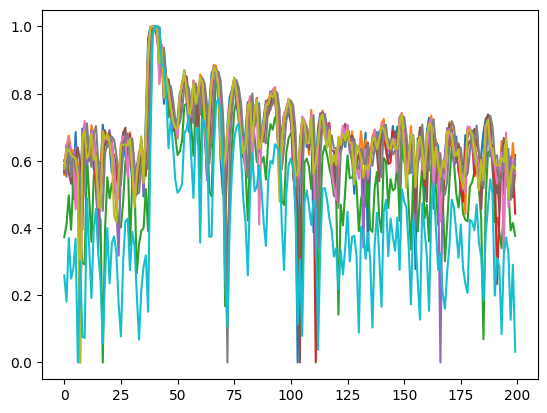

In [25]:
# Testing the logarithmic distortion

eps = 1e-5

for i in range(10):
    X1 = train_data[i]
    
    logX1 = np.log(X1+eps)

    logX1 = (logX1 - logX1.min())/(logX1.max() - logX1.min())

    plt.plot(logX1)
    # plt.plot(X1)

plt.show()